# Computation of scores for the test predictions

In [28]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image

# Define dataset paths
path_test = "../dataset_test"
path_test_raw = "raw_masks/test"  # Ground truth masks
path_raw_prediction = "raw_prediction"  # Raw predictions
path_post_prediction = "post_prediction"  # Post-processed predictions
raw_images_folder = "../nnNet_training/Raw_data/Dataset_Train_val/imagesTr"  # Raw images

# Construct full paths
gt_folder = os.path.join(path_test, path_test_raw)
raw_pred_folder = os.path.join(path_test, path_raw_prediction)
post_pred_folder = os.path.join(path_test, path_post_prediction)

# Verify folders exist
assert os.path.exists(gt_folder), f"❌ ERROR: Ground truth folder not found: {gt_folder}"
assert os.path.exists(raw_pred_folder), f"❌ ERROR: Raw prediction folder not found: {raw_pred_folder}"
assert os.path.exists(post_pred_folder), f"❌ ERROR: Post-processed prediction folder not found: {post_pred_folder}"
assert os.path.exists(raw_images_folder), f"❌ ERROR: Raw images folder not found: {raw_images_folder}"

print("✅ All folders verified and exist!")

✅ All folders verified and exist!


In [39]:
# Function to match filenames based on your structure
def get_matching_pred_filename(gt_filename):
    """Convert '8_mask.png' -> 'sten_0007_0000.png' (raw image), 'sten_0007.png' (raw & post predictions)."""
    base_name = str(int(gt_filename.replace("_mask.png", "")) - 1)  # Adjust index by subtracting 1
    sten_name_raw = f"sten_{int(base_name):04d}_0000.png"  # Matches raw image
    sten_name_pred = f"sten_{int(base_name):04d}.png"  # Matches raw & post predictions
    return sten_name_raw, sten_name_pred, sten_name_pred

🔍 Example Matching: 8_mask.png → Raw Image: sten_0007_0000.png → Raw Prediction: sten_0007.png → Postprocessed: sten_0007.png


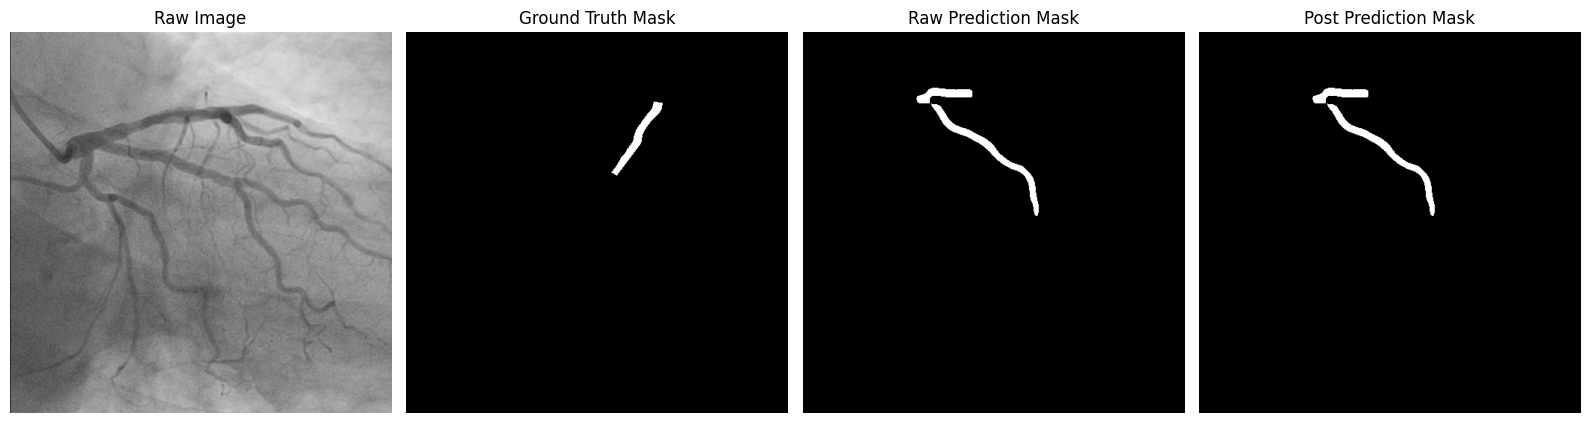

In [54]:
# Pick an example to verify matching
gt_file = "8_mask.png"
sten_raw, sten_pred, sten_post = get_matching_pred_filename(gt_file)
print(f"🔍 Example Matching: {gt_file} → Raw Image: {sten_raw} → Raw Prediction: {sten_pred} → Postprocessed: {sten_post}")

# Load example images
gt_mask = cv2.imread(os.path.join(gt_folder, random_gt_file), cv2.IMREAD_GRAYSCALE)
raw_pred_mask = cv2.imread(os.path.join(raw_pred_folder, sten_pred), cv2.IMREAD_GRAYSCALE)
post_pred_mask = cv2.imread(os.path.join(post_pred_folder, sten_post), cv2.IMREAD_GRAYSCALE)
raw_image = cv2.imread(os.path.join(raw_images_folder, sten_raw))  # Load raw image

# Plot the example for debugging
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
axes[0].imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Raw Image")
axes[0].axis("off")
axes[1].imshow(gt_mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")
axes[2].imshow(raw_pred_mask, cmap="gray")
axes[2].set_title("Raw Prediction Mask")
axes[2].axis("off")
axes[3].imshow(post_pred_mask, cmap="gray")
axes[3].set_title("Post Prediction Mask")
axes[3].axis("off")
plt.tight_layout()
plt.show()

In [48]:
# Function to compute evaluation metrics
def compute_metrics(gt_mask, pred_mask):
    """Compute Precision, Recall, and F1 Score between GT and predictions."""
    gt_mask = gt_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    precision = precision_score(gt_mask, pred_mask, average="binary", zero_division=0)
    recall = recall_score(gt_mask, pred_mask, average="binary", zero_division=0)
    f1 = f1_score(gt_mask, pred_mask, average="binary", zero_division=0)
    
    return precision, recall, f1

# Compute scores for one example
precision_raw, recall_raw, f1_raw = compute_metrics(gt_mask, raw_pred_mask)
precision_post, recall_post, f1_post = compute_metrics(gt_mask, post_pred_mask)

print("\n✅ **Example Scores**")
print(f"📌 **Raw Prediction** - Precision: {precision_raw:.4f}, Recall: {recall_raw:.4f}, F1-Score: {f1_raw:.4f}")
print(f"📌 **Postprocessed Prediction** - Precision: {precision_post:.4f}, Recall: {recall_post:.4f}, F1-Score: {f1_post:.4f}")



✅ **Example Scores**
📌 **Raw Prediction** - Precision: 0.2987, Recall: 0.5359, F1-Score: 0.3836
📌 **Postprocessed Prediction** - Precision: 0.0030, Recall: 0.0036, F1-Score: 0.0033


In [42]:
# Compute IoU and Dice Score
def compute_iou_dice(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    iou = intersection / union if union != 0 else 0.0
    dice = (2 * intersection) / (gt_mask.sum() + pred_mask.sum()) if (gt_mask.sum() + pred_mask.sum()) != 0 else 0.0
    return iou, dice

# Compute scores for all files
all_metrics = []
for gt_file in sorted(os.listdir(gt_folder)):
    sten_raw, sten_pred, sten_post = get_matching_pred_filename(gt_file)
    
    gt_mask = cv2.imread(os.path.join(gt_folder, gt_file), cv2.IMREAD_GRAYSCALE)
    raw_pred_mask = cv2.imread(os.path.join(raw_pred_folder, sten_pred), cv2.IMREAD_GRAYSCALE)
    post_pred_mask = cv2.imread(os.path.join(post_pred_folder, sten_post), cv2.IMREAD_GRAYSCALE)
    
    if gt_mask is None or raw_pred_mask is None or post_pred_mask is None:
        print(f"⚠️ Skipping {gt_file} due to missing files.")
        continue
    
    if raw_pred_mask.shape != gt_mask.shape:
        raw_pred_mask = cv2.resize(raw_pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    if post_pred_mask.shape != gt_mask.shape:
        post_pred_mask = cv2.resize(post_pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    precision_raw, recall_raw, f1_raw = precision_score(gt_mask.flatten(), raw_pred_mask.flatten(), average="binary", zero_division=0), recall_score(gt_mask.flatten(), raw_pred_mask.flatten(), average="binary", zero_division=0), f1_score(gt_mask.flatten(), raw_pred_mask.flatten(), average="binary", zero_division=0)
    precision_post, recall_post, f1_post = precision_score(gt_mask.flatten(), post_pred_mask.flatten(), average="binary", zero_division=0), recall_score(gt_mask.flatten(), post_pred_mask.flatten(), average="binary", zero_division=0), f1_score(gt_mask.flatten(), post_pred_mask.flatten(), average="binary", zero_division=0)
    
    iou_raw, dice_raw = compute_iou_dice(gt_mask, raw_pred_mask)
    iou_post, dice_post = compute_iou_dice(gt_mask, post_pred_mask)
    
    all_metrics.append([gt_file, precision_raw, recall_raw, f1_raw, iou_raw, dice_raw, precision_post, recall_post, f1_post, iou_post, dice_post])

# Compute average scores
import pandas as pd
metrics_df = pd.DataFrame(all_metrics, columns=["File", "Precision_Raw", "Recall_Raw", "F1_Raw", "IoU_Raw", "Dice_Raw", "Precision_Post", "Recall_Post", "F1_Post", "IoU_Post", "Dice_Post"])
avg_metrics = metrics_df.mean(numeric_only=True)

print("\n✅ **Final Evaluation Scores (Averaged over all files)**")
print(avg_metrics)


✅ **Final Evaluation Scores (Averaged over all files)**
Precision_Raw     0.647204
Recall_Raw        0.602455
F1_Raw            0.577702
IoU_Raw           0.434154
Dice_Raw          0.577702
Precision_Post    0.635485
Recall_Post       0.558851
F1_Post           0.555894
IoU_Post          0.425367
Dice_Post         0.555894
dtype: float64


In [50]:
# push to csv
metrics_df.to_csv("../dataset_test/evaluation_metrics.csv", index=False)